## Mount drive and navigate to project folder

In [38]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
%cd /content/drive/My Drive/Colab Notebooks/


/content/drive/My Drive/Colab Notebooks


In [40]:
%cd UDEMY_EMOTION_AI/

/content/drive/My Drive/Colab Notebooks/UDEMY_EMOTION_AI


# PART 1. FACIAL KEY POINTS DETECTION

In [41]:
# Import the necessary packages
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

### LOAD THE DATASET

In [42]:
# load facial key points data
keyfacial_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/UDEMY_EMOTION_AI/data.csv')

In [43]:
keyfacial_df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2135,67.180378,35.816373,33.239956,34.921932,59.347973,37.000904,72.667896,37.097600,39.404349,36.589944,24.972418,36.348203,56.402841,31.171586,80.709708,30.595738,38.187845,30.595738,17.275454,29.534964,45.805390,60.065396,64.397610,73.248393,35.446431,74.014748,48.708626,76.760852,48.559612,77.335618,191 191 191 190 189 185 184 120 54 34 19 24 31...
2136,65.724490,36.301020,25.377551,37.311224,58.530612,37.739796,74.448980,37.525510,33.551020,38.107143,15.979592,38.076531,56.941270,29.605102,81.314059,30.754762,35.059410,29.566780,8.578912,32.096032,53.649433,62.472789,66.928121,79.229046,28.015377,81.151722,48.771976,81.816774,49.287271,82.871156,19 19 19 18 13 7 3 4 3 1 3 9 11 12 12 13 10 9 ...
2137,68.430866,38.651975,28.895857,37.617027,61.659350,40.100902,75.586792,40.219182,37.665118,39.087245,21.621652,39.095524,62.388142,32.089787,85.829396,38.724104,42.595762,30.541779,11.230184,34.485512,53.318891,63.289576,68.864397,77.495823,22.013981,77.368995,49.180628,79.043130,47.176739,89.544522,31 40 47 31 54 58 63 100 86 80 82 75 79 86 90 ...
2138,64.152180,30.691592,27.000898,40.868082,56.505624,34.126963,73.436776,28.556335,34.746122,40.506939,16.850204,44.409861,51.463469,27.161327,77.354898,19.562755,34.135510,32.830102,9.731633,41.152347,54.075935,59.735799,73.730743,70.273886,38.777143,80.684286,58.042857,79.301429,58.611086,80.355543,7 1 5 1 3 20 12 0 5 8 6 18 13 9 8 12 12 11 4 8...


In [44]:
# Check if null values exist in the dataframe
keyfacial_df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [45]:
# The images are located in the last column and pixels coded into text
keyfacial_df['Image']

0       238 236 237 238 240 240 239 241 241 243 240 23...
1       219 215 204 196 204 211 212 200 180 168 178 19...
2       144 142 159 180 188 188 184 180 167 132 84 59 ...
3       193 192 193 194 194 194 193 192 168 111 50 12 ...
4       147 148 160 196 215 214 216 217 219 220 206 18...
                              ...                        
2135    191 191 191 190 189 185 184 120 54 34 19 24 31...
2136    19 19 19 18 13 7 3 4 3 1 3 9 11 12 12 13 10 9 ...
2137    31 40 47 31 54 58 63 100 86 80 82 75 79 86 90 ...
2138    7 1 5 1 3 20 12 0 5 8 6 18 13 9 8 12 12 11 4 8...
2139    68 19 19 23 19 26 23 16 8 15 9 9 17 16 15 27 2...
Name: Image, Length: 2140, dtype: object

In [46]:
type(keyfacial_df['Image'][0])

str

In [47]:
# Convert 'Image' field from text back to images which can be displayed
# Since values for the image are given as space separated string, separate the values using ' ' as separator.
# Then convert this into numpy array using np.fromstring and convert the obtained 1D array into 2D array of shape (96, 96)
keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(96, 96))

In [48]:
# verify the shape of the image
keyfacial_df['Image'][0].shape

(96, 96)

### VISUALIZE IMAGES

In [49]:
def display_image_and_keypoints(df):
  '''display a ramdom image and the associated keypoints from a dataset df'''
  i = np.random.randint(1, len(df))
  plt.imshow(df['Image'][i], cmap = 'gray')
  for j in range(1, 31, 2):
          plt.plot(df.loc[i][j-1], df.loc[i][j], 'rx')

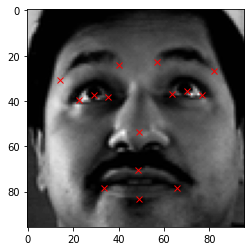

In [50]:
# Plot a random image from the dataset along with facial keypoints. 
# Image data is obtained from df['Image'] and plotted using plt.imshow
# 15 x and y coordinates for the corresponding image 
# since x-coordinates are in even columns like 0,2,4,.. and y-coordinates are in odd columns like 1,3,5,..
# we access their value using .loc command, which get the values for coordinates of the image based on the column it is refering to.

display_image_and_keypoints(keyfacial_df)

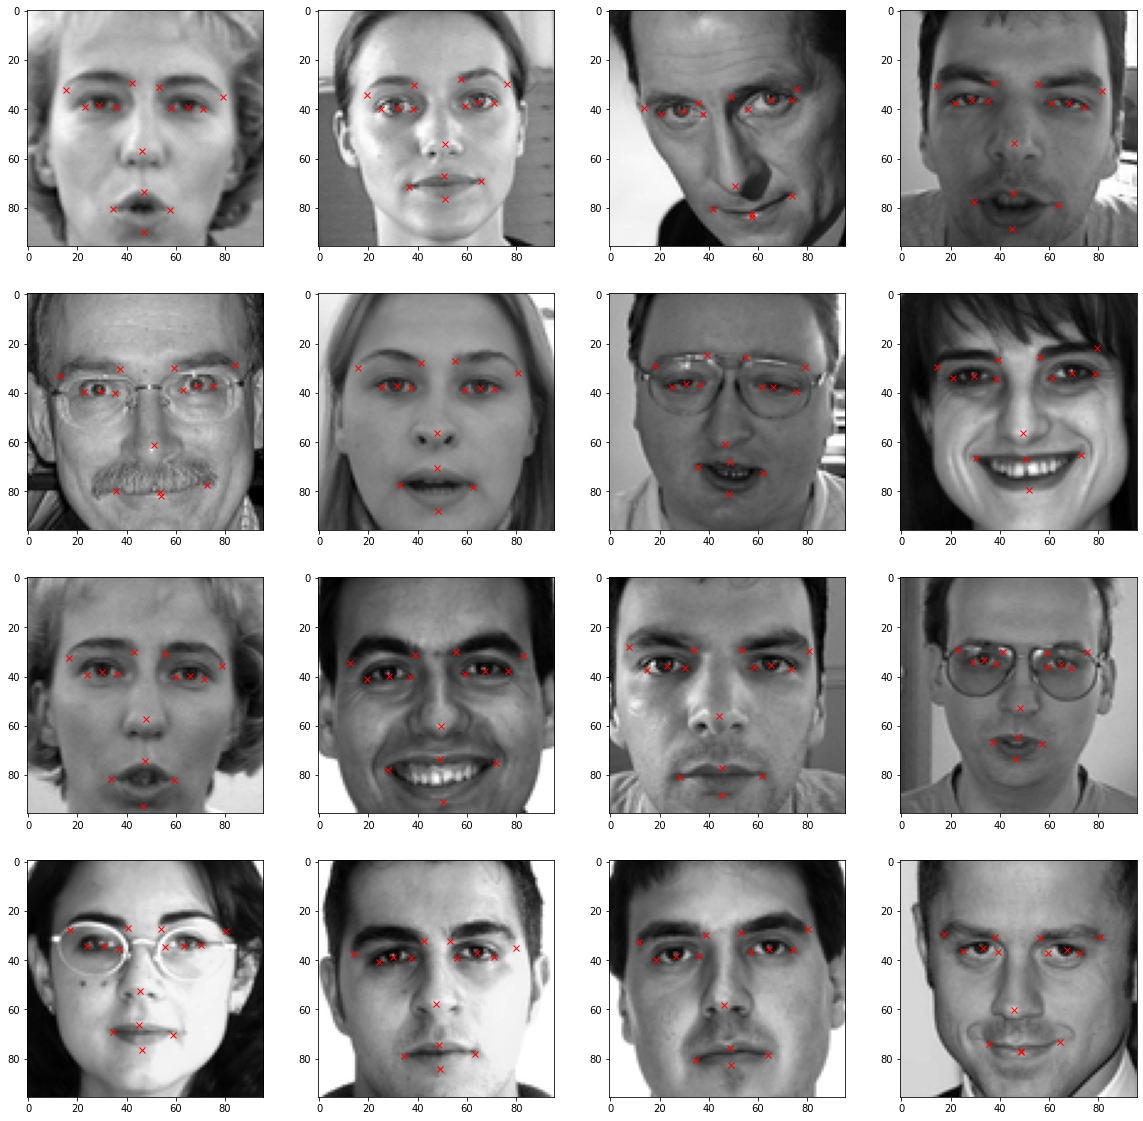

In [51]:
# Let's view more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)    
    display_image_and_keypoints(keyfacial_df)    

### PERFORM IMAGE AUGMENTATION

In [52]:
# Create a new copy of the dataframe
import copy
keyfacial_df_copy = copy.copy(keyfacial_df)

In [53]:
# Obtain the columns in the dataframe
columns = keyfacial_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [54]:
# Horizontal Flip - flip the images along y axis
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))

# since we are flipping horizontally, y coordinate values would be the same
# Only x coordiante values would change, all we have to do is to subtract our initial x-coordinate values from width of the image(96)
for i in range(len(columns)):
  if i%2 == 0:
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

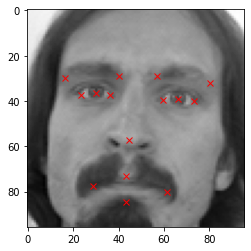

In [55]:
# Show the Original image
plt.imshow(keyfacial_df['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'rx')

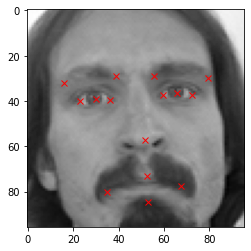

In [56]:
# Show the Horizontally flipped image
plt.imshow(keyfacial_df_copy['Image'][0],cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [57]:
# Concatenate the original dataframe with the augmented dataframe
augmented_df = np.concatenate((keyfacial_df, keyfacial_df_copy))

In [58]:
augmented_df.shape

(4280, 31)

In [59]:
# Randomingly increasing the brightness of the images
# We multiply pixel values by random values between 1.5 and 2 to increase the brightness of the image
# we clip the value between 0 and 255
import random
keyfacial_df_copy = copy.copy(keyfacial_df)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x:np.clip(random.uniform(1.5, 2)* x, 0.0, 255.0))
augmented_df = np.concatenate((augmented_df, keyfacial_df_copy))
augmented_df.shape

(6420, 31)

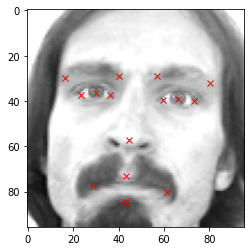

In [60]:
# Show Image with increased brightness

plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

### PERFORM DATA NORMALIZATION AND TRAINING DATA PREPARATION

In [61]:
# Obtain the value of images which is present in the 31st column (since index start from 0, we refer to 31st column by 30)
img = augmented_df[:,30]

# Normalize the images
img = img/255.

# Create an empty array of shape (x, 96, 96, 1) to feed the model
X = np.empty((len(img), 96, 96, 1))

# Iterate through the img list and add image values to the empty array after expanding it's dimension from (96, 96) to (96, 96, 1)
for i in range(len(img)):
  X[i,] = np.expand_dims(img[i], axis = 2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(6420, 96, 96, 1)

In [62]:
# Obtain the value of x & y coordinates which are to used as target.
y = augmented_df[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape

(6420, 30)

In [63]:
# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [64]:
X_train.shape

(5136, 96, 96, 1)

In [65]:
X_test.shape

(1284, 96, 96, 1)

### BUILD DEEP RESIDUAL NEURAL NETWORK KEY FACIAL POINTS DETECTION MODEL 

In [66]:
# RES_BLOCK
def res_block(X, filter, stage):

  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [67]:
# FACIAL KEYPOINT DETECTION MODEL
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128,128,512], stage= 3)


# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model_1_facialKeyPoints = Model( inputs= X_input, outputs = X)
model_1_facialKeyPoints.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

### COMPILE AND TRAIN KEY FACIAL POINTS DETECTION DEEP LEARNING MODEL

In [68]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
# using of MSE loss metric as we are doing regression to predict coordinates in a continuous space
model_1_facialKeyPoints.compile(loss = "mean_squared_error", optimizer = adam , metrics = ['accuracy'])

In [69]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = "FacialKeyPoints_weights.hdf5", verbose = 1, save_best_only = True)

In [70]:
history = model_1_facialKeyPoints.fit(X_train, y_train, batch_size = 256, epochs = 15, validation_split = 0.05, callbacks=[checkpointer])

Epoch 1/15
20/20 [==============================] - 37s 157ms/step - loss: 1016.4392 - accuracy: 0.5308 - val_loss: 2423.9780 - val_accuracy: 0.0078

Epoch 00001: val_loss improved from inf to 2423.97803, saving model to FacialKeyPoints_weights.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
20/20 [==============================] - 2s 114ms/step - loss: 215.4634 - accuracy: 0.4466 - val_loss: 2178.6003 - val_accuracy: 0.6965

Epoch 00002: val_loss improved from 2423.97803 to 2178.60034, saving model to FacialKeyPoints_weights.hdf5
Epoch 3/15
20/20 [==============================] - 2s 114ms/step - loss: 178.1833 - accuracy: 0.5673 - val_loss: 1942.3781 - val_accuracy: 0.6965

Epoch 00003: val_loss improved from 2178.60034 to 1942.37805, saving model to FacialKeyPoints_weights.hdf5
Epoch 4/15
20/20 [==============================] - 2s 115ms/step - loss: 168.7961 - accuracy: 0.6194 - val_loss: 1706.4261 - val_accuracy: 0.6965

Epoch 00004: val_loss improved from 1942.37805 to 1706.42615, saving model to FacialKeyPoints_weights.hdf5
Epoch 5/15
20/20 [==============================] - 2s 114ms/step - loss: 158.6947 - accuracy: 0.6118 - val_loss: 1475.7767 - val_accuracy: 0.6965

Epoch 00005: val_loss improved from 1706.42615 to 1475.77673, saving model to FacialKey

In [71]:
# save the model architecture to json file for future use
model_json = model_1_facialKeyPoints.to_json()
with open("FacialKeyPoints-model.json","w") as json_file:
  json_file.write(model_json)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### ASSESS TRAINED KEY FACIAL POINTS DETECTION MODEL PERFORMANCE

In [72]:
# Load best model weights (if provided)
with open('detection.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model_1_facialKeyPoints = tf.keras.models.model_from_json(json_savedModel)
model_1_facialKeyPoints.load_weights('weights_keypoint.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_1_facialKeyPoints.compile(loss="mean_squared_error", optimizer= adam , metrics = ['accuracy'])

In [73]:
# Evaluate the model
result = model_1_facialKeyPoints.evaluate(X_test, y_test)
print("Accuracy : {}".format(result[1]))

41/41 [==============================] - 1s 12ms/step - loss: 7.1091 - accuracy: 0.8458
Accuracy : 0.8457943797111511


In [74]:
# Get the model keys 
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

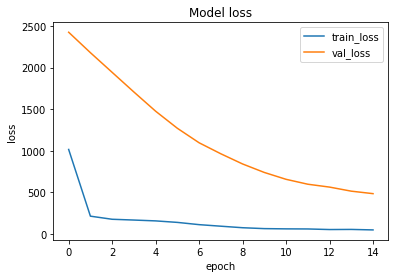

In [75]:
# Plot the training artifacts
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

# PART 2. FACIAL EXPRESSION DETECTION

### IMPORT & EXPLORE DATASET FOR FACIAL EXPRESSION DETECTION

In [76]:
# read the csv files for the facial expression data
facialexpression_df = pd.read_csv('icml_face_data.csv')

In [77]:
facialexpression_df

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3,2,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
...,...,...
24563,3,0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
24564,0,181 177 176 156 178 144 136 132 122 107 131 16...
24565,3,178 174 172 173 181 188 191 194 196 199 200 20...
24566,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...


In [78]:
facialexpression_df[' pixels'][0] # String format

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [79]:
# function to convert pixel values in string format to array format
def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [80]:
# Resize images from (48, 48) to (96, 96)
def resize(x):
  img = x.reshape(48, 48)
  return cv2.resize(img, dsize=(96, 96), interpolation = cv2.INTER_CUBIC)

In [81]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: string2array(x))

In [82]:
facialexpression_df[' pixels'] = facialexpression_df[' pixels'].apply(lambda x: resize(x))

In [83]:
facialexpression_df.head()

,emotion,pixels
0,0,"[[69.316925, 73.03865, 79.13719, 84.17186, 85...."
1,0,"[[151.09435, 150.91393, 150.65791, 148.96367, ..."
2,2,"[[23.061905, 25.50914, 29.47847, 33.99843, 36...."
3,2,"[[20.083221, 19.079437, 17.398712, 17.158691, ..."
4,3,"[[76.26172, 76.54747, 77.001785, 77.7672, 78.4..."


In [84]:
# check the shape of data_frame
facialexpression_df.shape

(24568, 2)

In [85]:
label_to_text = {0:'anger', 1:'disgust', 2:'sad', 3:'happiness', 4: 'surprise'}

### VISUALIZE IMAGES AND PLOT LABELS

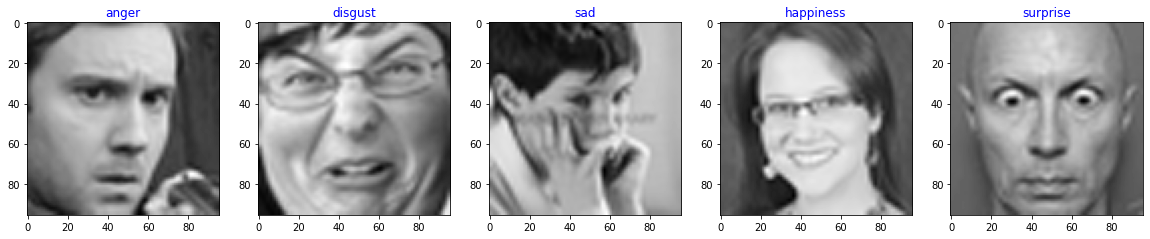

In [86]:
emotions = [0, 1, 2, 3, 4]
fig = plt.figure(figsize=(20, 20))

for i in emotions:
  ax = fig.add_subplot(1, 5, i+1) 
  data = facialexpression_df[facialexpression_df['emotion'] == i][:1]
  img = data[' pixels'].item()
  img = img.reshape(96, 96)
  plt.title(label_to_text[i], fontdict={'color':'blue'})
  plt.imshow(img, cmap = 'gray')

In [88]:
facialexpression_df.emotion.value_counts()

3    8989
2    6077
0    4953
4    4002
1     547
Name: emotion, dtype: int64

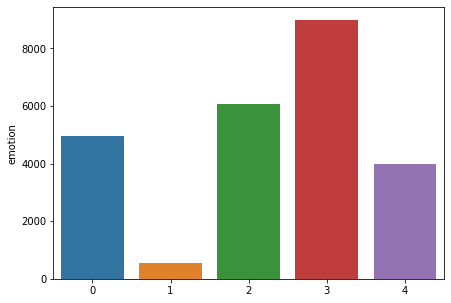

In [90]:
plt.figure(figsize = (7,5))
sns.barplot(x = facialexpression_df.emotion.value_counts().index, y = facialexpression_df.emotion.value_counts())

### PERFORM DATA PREPARATION AND IMAGE AUGMENTATION

In [91]:
# split the dataframe in to features and labels
from tensorflow.keras.utils import to_categorical

X = facialexpression_df[' pixels']
y = to_categorical(facialexpression_df['emotion'])

In [92]:
X[0]

array([[ 69.316925,  73.03865 ,  79.13719 , ...,  40.73619 ,  40.6584  ,
         40.5394  ],
       [ 68.66325 ,  70.95224 ,  74.71768 , ...,  43.274765,  42.037186,
         41.223618],
       [ 67.768814,  67.71646 ,  67.67172 , ...,  47.39473 ,  44.26329 ,
         42.31465 ],
       ...,
       [ 74.89021 ,  76.79553 ,  79.90259 , ...,  71.463425,  59.32875 ,
         51.74736 ],
       [ 76.68126 ,  75.808105,  74.25452 , ...,  93.943375,  79.77934 ,
         71.13246 ],
       [ 77.63858 ,  75.15074 ,  70.8846  , ..., 107.66351 ,  92.23212 ,
         82.91585 ]], dtype=float32)

In [93]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [94]:
X.shape

(24568,)

In [95]:
X[0].shape

(96, 96)

In [96]:
X = np.stack(X, axis = 0)
X = X.reshape(24568, 96, 96, 1)

print(X.shape, y.shape)

(24568, 96, 96, 1) (24568, 5)


In [97]:
# split the dataframe in to train, test and validation data frames
X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test, y_Test, test_size = 0.5, shuffle = True)

In [98]:
print(X_val.shape, y_val.shape)

(1228, 96, 96, 1) (1228, 5)


In [99]:
print(X_Test.shape, y_Test.shape)

(1229, 96, 96, 1) (1229, 5)


In [100]:
print(X_train.shape, y_train.shape)

(22111, 96, 96, 1) (22111, 5)


In [101]:
# image pre-processing
X_train = X_train/255
X_val   = X_val /255
X_Test  = X_Test/255

In [102]:
train_datagen = ImageDataGenerator(
                                  rotation_range = 15,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  shear_range = 0.1,
                                  zoom_range = 0.1,
                                  horizontal_flip = True,
                                  brightness_range=(0.0,0.1),
                                  fill_mode = "nearest"
                                  )

### BUILD AND TRAIN DEEP LEARNING MODEL FOR FACIAL EXPRESSION CLASSIFICATION

In [103]:
input_shape = (96, 96, 1)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - stage
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - stage
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128, 128, 512], stage= 3)

# Average Pooling
X = AveragePooling2D((4, 4), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_2_emotion = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_2_emotion.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 102, 102, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [104]:
# train the network
# Here we are using categorical_crossentropy loss metric as we are predicting multiclasses (binary crossentropy otherwise)
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [105]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = "FacialExpression_weights.hdf5", verbose = 1, save_best_only=True)

In [106]:
history = model_2_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=256),
	validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 256,
	epochs= 15, callbacks=[checkpointer, earlystopping])

Epoch 1/15
86/86 [==============================] - 30s 319ms/step - loss: 1.5735 - accuracy: 0.3614 - val_loss: 1.4284 - val_accuracy: 0.3738

Epoch 00001: val_loss improved from inf to 1.42838, saving model to FacialExpression_weights.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
86/86 [==============================] - 27s 316ms/step - loss: 1.2441 - accuracy: 0.4712 - val_loss: 1.4407 - val_accuracy: 0.3795

Epoch 00002: val_loss did not improve from 1.42838
Epoch 3/15
86/86 [==============================] - 26s 305ms/step - loss: 1.0863 - accuracy: 0.5520 - val_loss: 1.4147 - val_accuracy: 0.3738

Epoch 00003: val_loss improved from 1.42838 to 1.41466, saving model to FacialExpression_weights.hdf5
Epoch 4/15
86/86 [==============================] - 28s 319ms/step - loss: 0.9868 - accuracy: 0.5953 - val_loss: 1.4204 - val_accuracy: 0.3738

Epoch 00004: val_loss did not improve from 1.41466
Epoch 5/15
86/86 [==============================] - 28s 321ms/step - loss: 0.9108 - accuracy: 0.6345 - val_loss: 1.3536 - val_accuracy: 0.4650

Epoch 00005: val_loss improved from 1.41466 to 1.35362, saving model to FacialExpression_weights.hdf5
Epoch 6/15
86/86 [==============================] - 26s 301ms/step - loss: 0.8634 - accuracy: 0.6617 - val_loss: 1.276

In [107]:
# saving the model architecture to json file for future use

model_json = model_2_emotion.to_json()
with open("FacialExpression-model.json","w") as json_file:
  json_file.write(model_json)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### ASSESS THE PERFORMANCE OF TRAINED FACIAL EXPRESSION CLASSIFIER MODEL

In [108]:
with open('emotion.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model_2_emotion = tf.keras.models.model_from_json(json_savedModel)
# load pretrained model weigths (provided)
model_2_emotion.load_weights('weights_emotions.hdf5')
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [109]:
score = model_2_emotion.evaluate(X_Test, y_Test)
print('Test Accuracy: {}'.format(score[1]))

39/39 [==============================] - 1s 14ms/step - loss: 0.3552 - accuracy: 0.8592
Test Accuracy: 0.8592351675033569


In [110]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

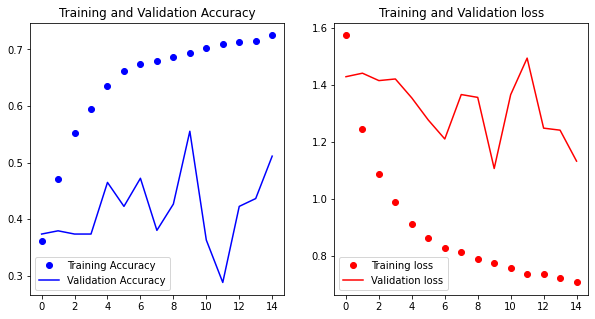

In [113]:
epochs = range(len(accuracy))
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1,2, 1) 
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

ax = fig.add_subplot(1,2, 2) 
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [115]:
# predicted_classes = model.predict_classes(X_test)
# collect the index of the highest prediction probability corrsponding to the predicted emotion class
predicted_classes = np.argmax(model_2_emotion.predict(X_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

In [116]:
y_true.shape

(1229,)

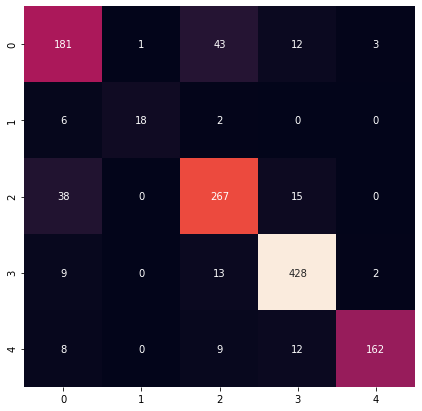

In [118]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (7, 7))
sns.heatmap(cm, annot = True, cbar = False, fmt = 'd')
plt.show()

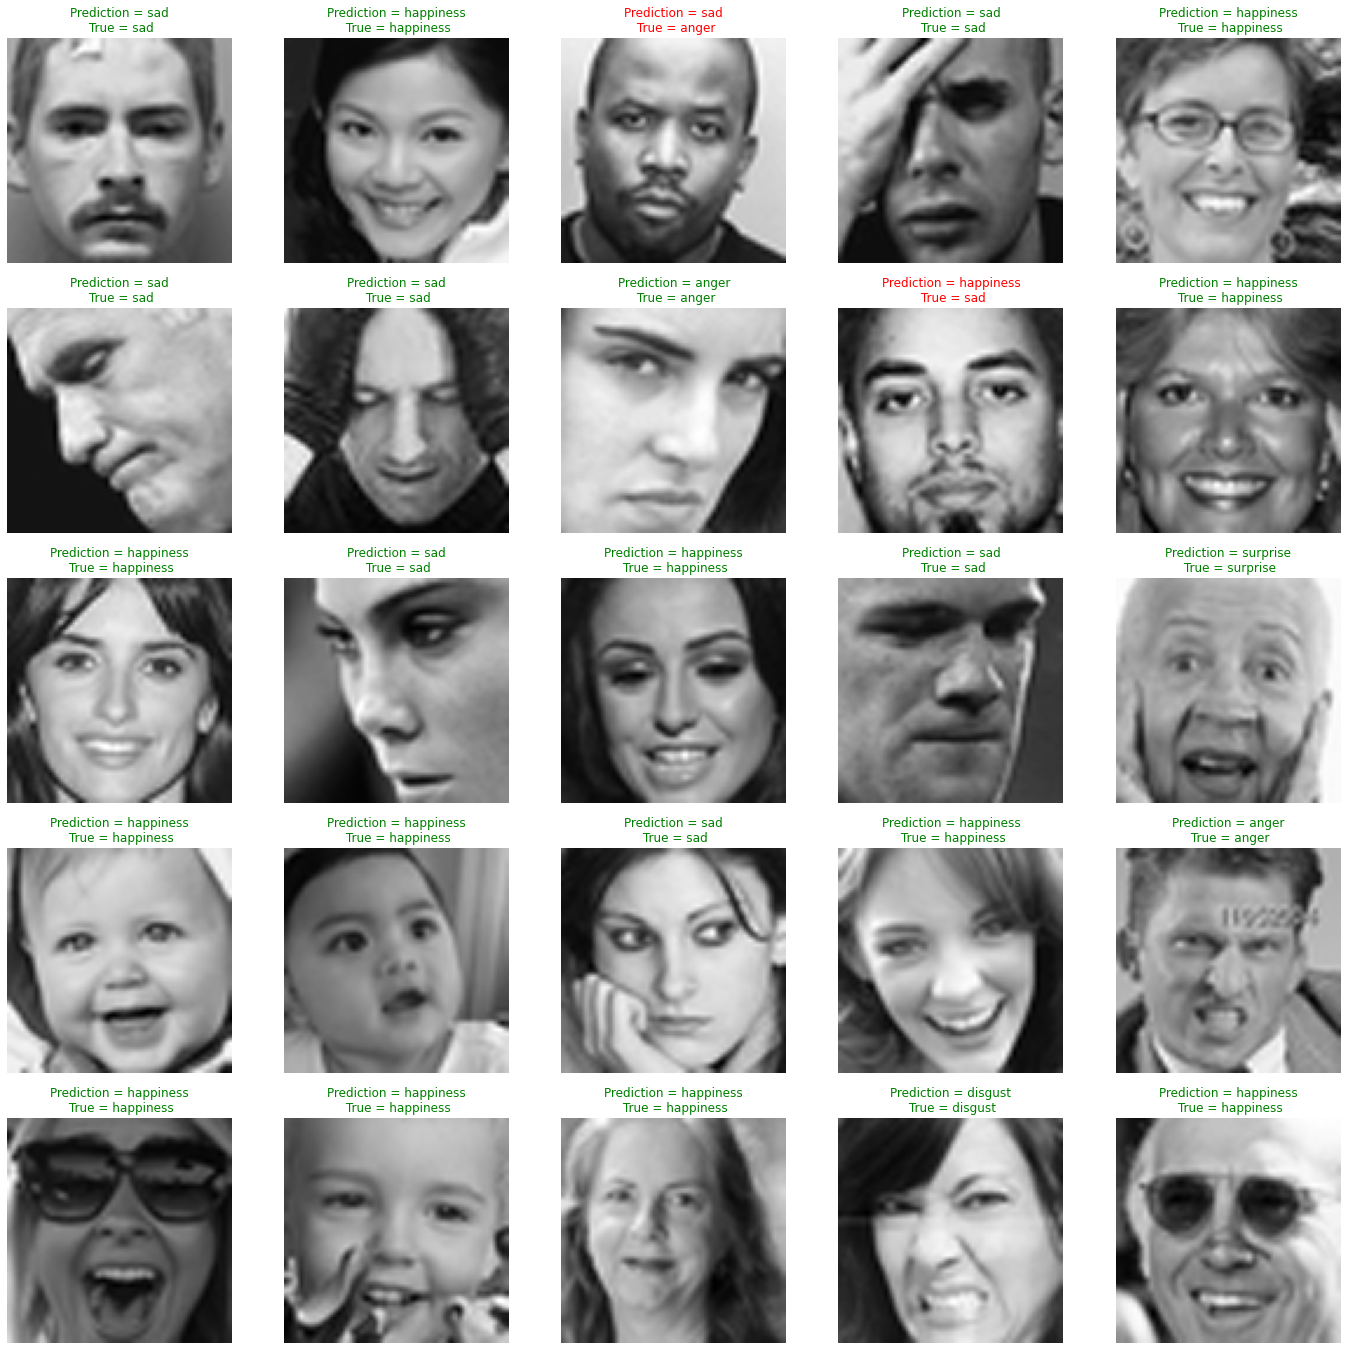

In [121]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()
for i in np.arange(0, L*W):
    j = np.random.randint(1, len(X_Test))
    prediction = predicted_classes[j]
    ground_truth = y_true[j]
    axes[i].imshow(X_Test[j].reshape(96,96), cmap = 'gray')
    axes[i].set_title('Prediction = {}\n True = {}'.format(label_to_text[prediction], label_to_text[ground_truth]),color=("green" if label_to_text[prediction]==label_to_text[ground_truth] else "red"))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.2)   

In [122]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75       240
           1       0.95      0.69      0.80        26
           2       0.80      0.83      0.82       320
           3       0.92      0.95      0.93       452
           4       0.97      0.85      0.91       191

    accuracy                           0.86      1229
   macro avg       0.88      0.82      0.84      1229
weighted avg       0.86      0.86      0.86      1229



# PART 3. COMBINE BOTH FACIAL EXPRESSION AND KEY POINTS DETECTION MODELS

### COMBINE BOTH MODELS (1) FACIAL KEY POINTS DETECTION AND (2) FACIAL EXPRESSION MODELS

In [123]:
def predict(X_test):

  # Making prediction from the keypoint model
  df_predict = model_1_facialKeyPoints.predict(X_test)

  # Making prediction from the emotion model
  df_emotion = np.argmax(model_2_emotion.predict(X_test), axis=-1)

  # Reshaping array from (856,) to (856,1)
  df_emotion = np.expand_dims(df_emotion, axis = 1)

  # Converting the predictions into a dataframe
  df_predict = pd.DataFrame(df_predict, columns= columns)

  # Adding emotion into the predicted dataframe
  df_predict['emotion'] = df_emotion

  return df_predict

In [124]:
df_predict = predict(X_test)

In [125]:
df_predict.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,emotion
0,66.019012,37.420177,29.088043,37.511650,58.224102,38.282360,74.591934,38.013069,36.964279,38.165733,20.532883,38.370628,55.602585,28.587132,81.385727,30.466623,39.116119,28.491869,13.469106,31.833939,47.389839,58.926788,68.748634,71.107872,26.509199,71.777641,47.551239,71.865211,47.644047,85.583412,3
1,67.323242,37.460827,28.171785,35.688187,59.146378,37.892391,75.801102,38.577988,36.113060,36.628368,19.579103,36.171440,56.227295,28.154749,84.036186,32.241192,39.238487,27.167639,11.921910,30.274996,46.039719,60.258190,66.992897,75.499474,24.448137,74.016838,45.327045,73.906487,45.120247,88.250984,3
2,66.703064,38.642803,29.498856,38.705219,59.521244,39.343884,73.973373,39.510071,36.379574,39.203079,21.685472,39.491631,55.019066,32.296326,79.585091,30.153868,39.351936,32.066517,15.028033,30.844250,48.609898,55.508736,64.590492,77.594833,32.237617,78.045166,48.003506,74.504959,48.275280,85.815193,0
3,66.352829,39.746761,30.018755,40.351181,58.860390,40.561489,74.425110,40.307636,37.535229,40.649853,21.956375,41.438290,55.160416,29.582781,81.192970,31.628151,40.415272,29.747501,14.432350,33.969028,48.041908,60.495399,68.170998,76.156769,29.698801,76.882362,48.684147,74.032173,48.840717,86.185539,3
4,67.677246,35.024487,28.830858,37.128902,60.042324,36.314682,75.693047,35.748444,36.356628,37.325150,20.738176,38.716373,55.134922,25.219915,82.575050,25.782284,38.119686,26.264872,12.745382,29.738602,48.118362,55.143040,66.415009,76.632744,35.580334,78.572357,50.121140,72.450516,50.821186,83.260857,2


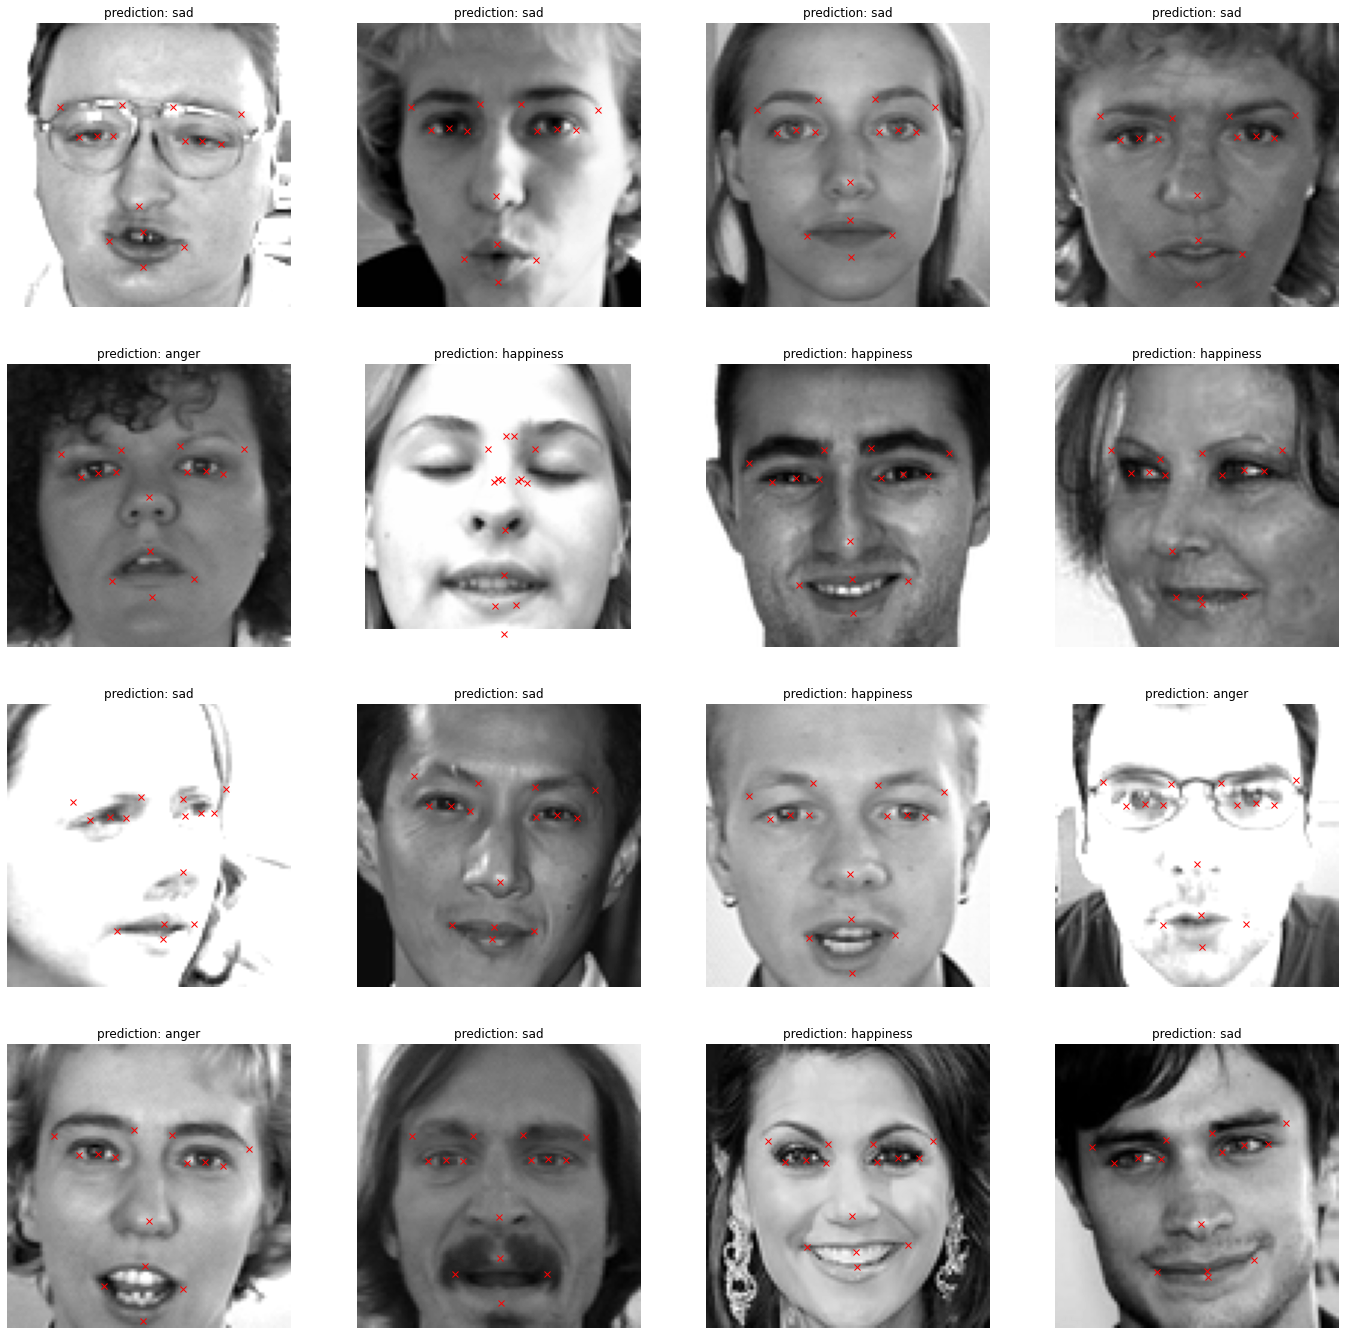

In [126]:
# Plotting the test images and their predicted keypoints and emotions
L = 4
W = 4

fig, axes = plt.subplots(L, W, figsize = (24, 24))
axes = axes.ravel()
for i in np.arange(0, L*W):
    j = np.random.randint(1, len(X_test))
    axes[i].imshow(X_test[j].reshape(96,96), cmap = 'gray')
    for k in range(1, 31, 2):
        axes[i].plot(df_predict.loc[j][k-1], df_predict.loc[j][k], 'rx')
    emotion = df_predict.loc[j,'emotion']
    axes[i].set_title("prediction: {}".format(label_to_text[emotion]))
    axes[i].axis('off')